# Test parameter shift using qiskit circuit

In [16]:
import numpy as np
from qiskit import *
from qiskit.tools.monitor import job_monitor
#import qiskit.tools.jupyter
from qiskit.tools.visualization import circuit_drawer, plot_histogram
import copy

## Target

Minimize the energy of two qubit going through one X gate using parameter shift rule


In [2]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
qc = QuantumCircuit(q,c)
qc.rxx(np.pi/2,1,0)
qc.ryy(np.pi/2,1,0)
qc.measure(q,c)
qc.draw()


┌───────────┐┌───────────┐┌─┐   
q0_0: ┤1          ├┤1          ├┤M├───
      │  Rxx(π/2) ││  Ryy(π/2) │└╥┘┌─┐
q0_1: ┤0          ├┤0          ├─╫─┤M├
      └───────────┘└───────────┘ ║ └╥┘
c0: 2/═══════════════════════════╩══╩═
                                 0  1

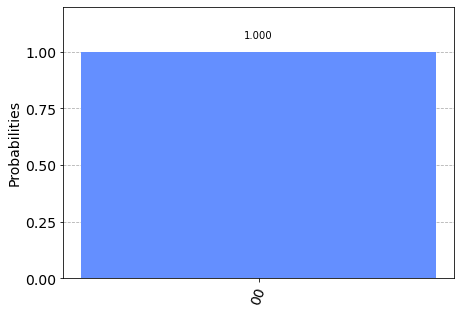

In [3]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=100)
plot_histogram(job.result().get_counts(qc))

## Create a variational ensemble
using $Z$ gate

In [72]:
N = 4
q = QuantumRegister(N)
c = ClassicalRegister(N)
qc = QuantumCircuit(q,c)

thetas = np.random.rand(3 * N)
for i in range(N):
    qc.rx(thetas[i] * np.pi/2,i)
    qc.ry(thetas[i] * np.pi/2,i)
    qc.rz(thetas[i] * np.pi/2,i)

qc.measure(q,c)
qc.draw()


┌─────────────┐┌─────────────┐┌─────────────┐┌─┐         
q187_0: ┤ Rx(0.27021) ├┤ Ry(0.27021) ├┤ Rz(0.27021) ├┤M├─────────
        └┬────────────┤└┬────────────┤└┬────────────┤└╥┘┌─┐      
q187_1: ─┤ Rx(1.5281) ├─┤ Ry(1.5281) ├─┤ Rz(1.5281) ├─╫─┤M├──────
        ┌┴────────────┤┌┴────────────┤┌┴────────────┤ ║ └╥┘┌─┐   
q187_2: ┤ Rx(0.35639) ├┤ Ry(0.35639) ├┤ Rz(0.35639) ├─╫──╫─┤M├───
        └┬────────────┤└┬────────────┤└┬────────────┤ ║  ║ └╥┘┌─┐
q187_3: ─┤ Rx(1.3368) ├─┤ Ry(1.3368) ├─┤ Rz(1.3368) ├─╫──╫──╫─┤M├
         └────────────┘ └────────────┘ └────────────┘ ║  ║  ║ └╥┘
 c63: 4/══════════════════════════════════════════════╩══╩══╩══╩═
                                                      0  1  2  3

In [84]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
testRes = job.result().get_counts(qc)

/Users/qwe/miniforge3/envs/qi/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/qwe/miniforge3/envs/qi/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [62]:
sigma_z = np.array([[1,0],[0,-1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,1],[1,0]])

spin = np.array([0,1])
spin_up = np.array([[1],[0]])
spin_down= np.array([[0],[1]])

In [20]:
class QuGateWithGrad:
    rDict = {'Rx': 0.5, 'Ry':0.5, 'Rz':0.5, 'Rxx': 0.5, 'Ryy': 0.5,'Rzz': 0.5}

    qiskitGateDict = {'Rx':QuantumCircuit.rx, 'Ry':QuantumCircuit.ry,'Rz':QuantumCircuit.rz,
    'Rxx':QuantumCircuit.rxx,'Ryy':QuantumCircuit.ryy,'Rzz':QuantumCircuit.rzz}

    def __init__(self,symbol: str, registerNum: tuple):
        self.qiskitGate = self.qiskitGateDict[symbol]
        self.r = self.rDict[symbol]
        
        self.registerNum = registerNum
        self.symbol = symbol
        self.gradNum = 0 # gradNum -1/+1 add or minus r
    
    
    def put(self,theta) -> tuple:
        
        return self.qiskitGate, theta + self.gradNum*( np.pi/ (4* self.r))
    

    def setGrad(self,gradNum):

        assert gradNum == -1 or gradNum == 1

        self.gradNum = gradNum
    
    

In [93]:
class QuCircWithGrad:

    simShots = 1000

    def __init__(self,N : int):
        self.thetas = []
        self.gates = []
        self.regiNums = []
        self.isConstructed = False
        self.qc = None
    
    def add_gate(self,symbol: str,registerNum: tuple,newTheta = None):
        '''
        add a gate with a random theta
        '''
        if type(registerNum) is int:
            registerNum = tuple([registerNum])
        
        if not newTheta:
            newTheta = np.random.random() * 2 * np.pi
        
        newGate = QuGateWithGrad(symbol,registerNum)
        self.regiNums.append(registerNum)
        self.gates.append(newGate)
        self.thetas.append(newTheta)

    def genGradCirc(self,gradIdx : int):
        """
        generate two circuit with plus and minus gradient
        """
        newCircPlus = copy.deepcopy(self)
        newCircMinus = copy.deepcopy(self)

        newCircPlus.gates[gradIdx].setGrad(1)
        newCircMinus.gates[gradIdx].setGrad(-1)

        newCircPlus.construct()
        newCircMinus.construct()

        return newCircPlus,newCircMinus


    def construct(self):
        '''
        construct the circuit using added gates and append measure
        '''
        self.isConstructed = True

        self.q = QuantumRegister(N)
        self.c = ClassicalRegister(N)
        self.qc = QuantumCircuit(self.q,self.c)

        for i in range(len(self.gates)):
            gate = self.gates[i]
            theta = self.thetas[i]
            registerNum = self.regiNums[i]
            kitGate, para = gate.put(theta)
            kitGate(self.qc,para,*registerNum)
        
        self.qc.measure(self.q,self.c)
    
    def getCircuit(self):
        assert self.isConstructed, "Circuit not constructed"
        return self.qc
    
    def size(self):
        """
        return the number of gates in the circuit
        """
        return len(self.gates)

    def updateThetas(self,newThetas):
        self.thetas = newThetas
        self.construct()
    
    def setCostFun(self,f):
        """
        set a cost function that have:
            input from the result of a circuit
            output a scalar
        """
        self.costFun = f
    
    def calc(self):

        backend = Aer.get_backend('qasm_simulator')
        job = execute(self.qc, backend, shots=self.simShots)
        res = job.result().get_counts(self.qc)
        cost = self.costFun(res)
        
        return cost
        

In [45]:
N = 4
test1 = QuCircWithGrad(N)

for i in range(N):
    test1.add_gate('Rx',i)

for i in range(N-1):
    test1.add_gate('Rxx',(i,i+1))
    test1.add_gate('Ryy',(i,i+1))
    test1.add_gate('Rzz',(i,i+1))

for j in range(N-1):
    i = (N-2 - i)
    test1.add_gate('Rxx',(i,i+1))
    test1.add_gate('Ryy',(i,i+1))
    test1.add_gate('Rzz',(i,i+1))


In [46]:
test1.construct()

MainQC = test1
gradCircs = []
for i in range(MainQC.size()):
    gradCircs.append(MainQC.genGradCirc(i))


    

In [81]:
testRes

{'1001': 7,
 '1110': 10,
 '0101': 1,
 '1011': 12,
 '0011': 13,
 '0001': 11,
 '1100': 11,
 '0100': 14,
 '0110': 13,
 '1010': 217,
 '0000': 227,
 '0010': 233,
 '1000': 231}

In [55]:
def state_to_vec(s):
    
    if s[0] == '1':
        state = spin_up
        state_mat = spin_up
    else:
        state = spin_down
        state_mat = spin_down
    
    for curr in s[1:]:
        if curr == '1':
            state = np.kron(state,spin_up)
            state_mat = np.hstack((state_mat,spin_up))
        else:
            state = np.kron(state,spin_down)
            state_mat = np.hstack((state_mat,spin_down))
    
    return state,state_mat

In [87]:
J = 0.1

H = np.zeros((2**N,2**N))

initLattice = np.kron(sigma_z,sigma_z)
for i in range(2,N):
    initLattice = np.kron(initLattice,np.eye(2))

H += - J * initLattice

for lattice_point in range(1,N-1):
    curr = np.eye(2)
    for i in range(1,lattice_point):
        curr = np.kron(curr,np.eye(2))
    curr = np.kron( np.kron(curr,sigma_z),sigma_z)
    for i in range(lattice_point+2,N):
        curr = np.kron(curr,np.eye(2))
    
    assert curr.shape[0] == H.shape[0]
    
    H += -J * curr


In [86]:
rho = np.zeros((N,N))
for key in testRes.keys():
    state, _ = state_to_vec(key)
    prob = testRes[key] / QuCircWithGrad.simShots
    rho += state * prob



1 [[0 1 1 1]
 [1 0 0 0]]


ValueError: operands could not be broadcast together with shapes (4,4) (16,1) (4,4) 